In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix,recall_score,precision_score,log_loss,f1_score,roc_auc_score,classification_report
from warnings import filterwarnings
import lightgbm as lgb
import tensorflow as tf
filterwarnings("ignore")
plt.style.use('ggplot')

In [2]:
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv")
y_test = pd.read_csv("y_test.csv")

In [3]:
X_train = X_train.drop('Unnamed: 0',axis=1).values
X_test = X_test.drop('Unnamed: 0',axis=1).values
y_train = y_train.drop('Unnamed: 0',axis=1).values.reshape(-1,1)
y_test = y_test.drop('Unnamed: 0',axis=1).values.reshape(-1,1)

In [4]:
rf_clf = RandomForestClassifier(n_jobs=10)

In [5]:
rf_clf.fit(X_train,y_train)

RandomForestClassifier(n_jobs=10)

In [6]:
pred_train = rf_clf.predict(X_train)
pred_test = rf_clf.predict(X_test)

In [4]:
cv = RepeatedStratifiedKFold(n_splits=5,n_repeats=2)

In [10]:
rf_param = {'n_estimators' : np.arange(60,120,15),
            'max_depth' : [1, 2, 3, 4, 5],
            'min_samples_leaf' : [1,2,5]
           }

In [11]:
rf_grid = GridSearchCV(estimator=rf_clf,
                       param_grid = rf_param,refit=True,
                       cv = cv, verbose=2, scoring='roc_auc')

In [12]:
rf_grid.fit(X_train,y_train)

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV] END ...max_depth=1, min_samples_leaf=1, n_estimators=60; total time=   5.8s
[CV] END ...max_depth=1, min_samples_leaf=1, n_estimators=60; total time=   4.0s
[CV] END ...max_depth=1, min_samples_leaf=1, n_estimators=60; total time=   4.1s
[CV] END ...max_depth=1, min_samples_leaf=1, n_estimators=60; total time=   4.1s
[CV] END ...max_depth=1, min_samples_leaf=1, n_estimators=60; total time=   3.7s
[CV] END ...max_depth=1, min_samples_leaf=1, n_estimators=60; total time=   3.2s
[CV] END ...max_depth=1, min_samples_leaf=1, n_estimators=60; total time=   3.6s
[CV] END ...max_depth=1, min_samples_leaf=1, n_estimators=60; total time=   3.2s
[CV] END ...max_depth=1, min_samples_leaf=1, n_estimators=60; total time=   3.4s
[CV] END ...max_depth=1, min_samples_leaf=1, n_estimators=60; total time=   3.2s
[CV] END ...max_depth=1, min_samples_leaf=1, n_estimators=75; total time=   3.9s
[CV] END ...max_depth=1, min_samples_leaf=1, n

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=None),
             estimator=RandomForestClassifier(n_jobs=10),
             param_grid={'max_depth': [1, 2, 3, 4, 5],
                         'min_samples_leaf': [1, 2, 5],
                         'n_estimators': array([ 60,  75,  90, 105])},
             scoring='roc_auc', verbose=2)

In [14]:
optimal_rf = rf_grid.best_estimator_

In [16]:
pred_train_opt = optimal_rf.predict(X_train)
pred_test_opt = optimal_rf.predict(X_test)

In [17]:
roc_auc_score(y_train,pred_train_opt)

0.8801878960056145

In [18]:
roc_auc_score(y_test,pred_test_opt)

0.7675840058353078

In [4]:
def get_metric(model):
    training_pred = model.predict(X_train)
    testing_pred = model.predict(X_test)
    
    print("The classification report for training is \n")
    print(classification_report(y_train,training_pred),"\n")
    
    print("The classification report for testing is \n")
    print(classification_report(y_test,testing_pred),"\n")
    
    print("The scores are summed up in the dataframe below")
    
    metrics = [roc_auc_score,accuracy_score,recall_score,precision_score,log_loss,f1_score]
    metric_name = ['Roc Auc','Accuracy','Recall','Precision','Log loss','F1 score']
    
    zipped_list = []
    for i in metrics:
        tr = round(i(y_train,training_pred),2)
        ts = round(i(y_test,testing_pred),2)
        zipped_list.append((tr,ts))
    metric_df = pd.DataFrame(zipped_list,index=metric_name,columns=['Train','Test'])    
    true_dict = pd.Series(y_test.flatten()).value_counts().to_dict()
    pred_dict = pd.Series(testing_pred).value_counts().to_dict()

    tmp_df = pd.DataFrame(zip(true_dict.values(),pred_dict.values()),columns = ['Actual','Predicted'],index=pred_dict.keys())
    tmp_df = tmp_df.div(tmp_df.sum(axis=0), axis=1)
    tmp_df.plot(kind='bar', rot=0, xlabel='Response',ylabel='Percentages', figsize=(14, 6))
#    plt.ylim((0, 100))
    
    return metric_df   

The classification report for training is 

              precision    recall  f1-score   support

           0       0.88      0.88      0.88    183758
           1       0.88      0.88      0.88    189957

    accuracy                           0.88    373715
   macro avg       0.88      0.88      0.88    373715
weighted avg       0.88      0.88      0.88    373715
 

The classification report for testing is 

              precision    recall  f1-score   support

           0       0.97      0.69      0.80     65137
           1       0.27      0.85      0.41      9021

    accuracy                           0.71     74158
   macro avg       0.62      0.77      0.61     74158
weighted avg       0.89      0.71      0.76     74158
 

The scores are summed up in the dataframe below


,Train,Test
Roc Auc,0.88,0.77
Accuracy,0.88,0.71
Recall,0.88,0.85
Precision,0.88,0.27
Log loss,4.14,10.11
F1 score,0.88,0.41


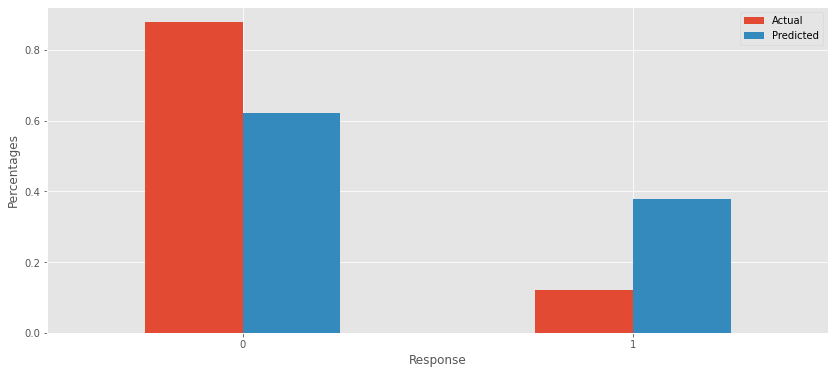

In [83]:
get_metric(optimal_rf)

In [6]:
svc_clf = SVC()

In [7]:
svc_param =   {'C': [0.1,1, 10, 100],
              'gamma': [1,0.1,0.01,0.001],
               }

In [9]:
svc_grid = RandomizedSearchCV(estimator=svc_clf,
                       param_distributions = svc_param,refit=True,n_jobs=-2,
                       cv = cv, verbose=2, scoring='roc_auc')

In [ ]:
svc_grid.fit(X_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [10]:
lgbm_clf = lgb.LGBMClassifier()

In [11]:
lgbm_clf.fit(X_train,y_train)

LGBMClassifier()

The classification report for training is 

              precision    recall  f1-score   support

           0       0.96      0.86      0.91    183758
           1       0.88      0.96      0.92    189957

    accuracy                           0.91    373715
   macro avg       0.92      0.91      0.91    373715
weighted avg       0.92      0.91      0.91    373715
 

The classification report for testing is 

              precision    recall  f1-score   support

           0       0.98      0.65      0.78     65137
           1       0.27      0.93      0.42      9021

    accuracy                           0.68     74158
   macro avg       0.63      0.79      0.60     74158
weighted avg       0.90      0.68      0.74     74158
 

The scores are summed up in the dataframe below


,Train,Test
Roc Auc,0.91,0.79
Accuracy,0.91,0.68
Recall,0.96,0.93
Precision,0.88,0.27
Log loss,2.94,10.94
F1 score,0.92,0.42


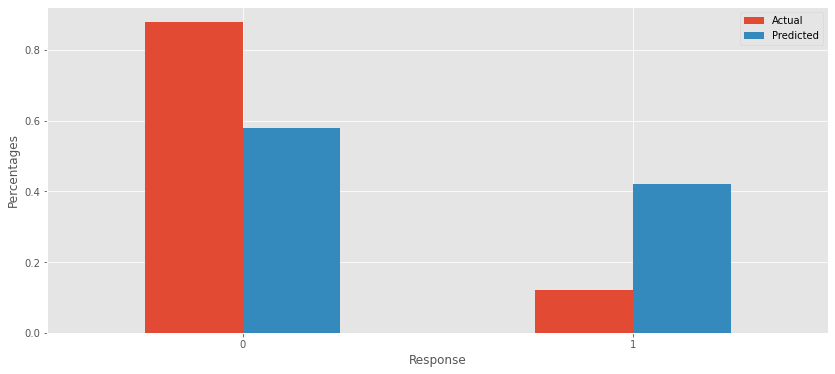

In [12]:
get_metric(lgbm_clf)

In [9]:
lgbm_param =   {'num_leaves': [6, 8, 12, 16],
                'n_estimators': [8, 16, 24],
                'learning_rate': [0.01,0.05],
                }

In [14]:
lgbm_grid = RandomizedSearchCV(estimator=lgbm_clf,
                       param_distributions = lgbm_param,refit=True,n_jobs=8,
                       cv = cv, verbose=2, scoring='roc_auc')

In [15]:
lgbm_grid.fit(X_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=None),
                   estimator=LGBMClassifier(), n_jobs=8,
                   param_distributions={'learning_rate': [0.01, 0.05],
                                        'n_estimators': [8, 16, 24],
                                        'num_leaves': [6, 8, 12, 16]},
                   scoring='roc_auc', verbose=2)

In [17]:
optimum_lgbm = lgbm_grid.best_estimator_

The classification report for training is 

              precision    recall  f1-score   support

           0       0.88      0.88      0.88    183758
           1       0.88      0.89      0.88    189957

    accuracy                           0.88    373715
   macro avg       0.88      0.88      0.88    373715
weighted avg       0.88      0.88      0.88    373715
 

The classification report for testing is 

              precision    recall  f1-score   support

           0       0.97      0.69      0.81     65137
           1       0.28      0.86      0.42      9021

    accuracy                           0.71     74158
   macro avg       0.62      0.77      0.61     74158
weighted avg       0.89      0.71      0.76     74158
 

The scores are summed up in the dataframe below


,Train,Test
Roc Auc,0.88,0.77
Accuracy,0.88,0.71
Recall,0.89,0.86
Precision,0.88,0.28
Log loss,4.09,10.04
F1 score,0.88,0.42


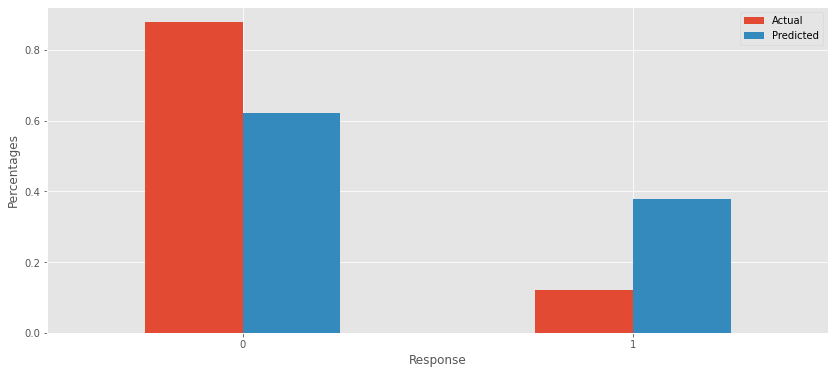

In [18]:
get_metric(optimum_lgbm)

In [5]:
X_train_nn, X_val, y_train_nn, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=0)

In [6]:
Y_train = to_categorical(y_train_nn, num_classes=None)
Y_val = to_categorical(y_val, num_classes=None)
Y_test = to_categorical(y_test, num_classes=None)

In [7]:
input_size = 5
output_size = 2
hidden_size = 10
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(hidden_size,'relu'),
                             tf.keras.layers.Dropout(0.25),
                             tf.keras.layers.Dense(hidden_size,'relu'),
                             tf.keras.layers.Dropout(0.25),
                             tf.keras.layers.Dense(output_size,'sigmoid')
                            ])
auc_met = tf.keras.metrics.AUC()
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=[auc_met])

early_stopping = tf.keras.callbacks.EarlyStopping(patience = 2)

In [8]:
network = model.fit(X_train_nn, Y_train, validation_data=(X_val,Y_val),epochs=50, batch_size=10,verbose = 2,callbacks = [early_stopping])

Epoch 1/50
29898/29898 - 32s - loss: 0.5048 - auc: 0.8359 - val_loss: 0.3702 - val_auc: 0.9156
Epoch 2/50
29898/29898 - 31s - loss: 0.3846 - auc: 0.9055 - val_loss: 0.3106 - val_auc: 0.9390
Epoch 3/50
29898/29898 - 31s - loss: 0.3549 - auc: 0.9189 - val_loss: 0.3001 - val_auc: 0.9386
Epoch 4/50
29898/29898 - 34s - loss: 0.3451 - auc: 0.9239 - val_loss: 0.2993 - val_auc: 0.9381
Epoch 5/50
29898/29898 - 34s - loss: 0.3436 - auc: 0.9243 - val_loss: 0.3093 - val_auc: 0.9378
Epoch 6/50
29898/29898 - 33s - loss: 0.3459 - auc: 0.9233 - val_loss: 0.2994 - val_auc: 0.9400


In [9]:
pred_train_nn = np.argmax(model.predict(X_train_nn), axis=1) 
pred_test_nn = np.argmax(model.predict(X_test), axis=1)

In [13]:
print(classification_report(y_train_nn,pred_train_nn))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83    146825
           1       0.82      0.90      0.86    152147

    accuracy                           0.85    298972
   macro avg       0.85      0.85      0.85    298972
weighted avg       0.85      0.85      0.85    298972



In [18]:
roc_auc_score(y_train_nn,pred_train_nn)

0.8453203808354612

In [14]:
print(classification_report(y_test,pred_test_nn))

              precision    recall  f1-score   support

           0       0.98      0.60      0.75     65137
           1       0.24      0.89      0.37      9021

    accuracy                           0.64     74158
   macro avg       0.61      0.75      0.56     74158
weighted avg       0.89      0.64      0.70     74158



In [20]:
roc_auc_score(y_test,pred_test_nn)

0.7456657463429892